# Figure 1
### Danielle Denisko

In [1]:
import os
from IPython.display import Image
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2,venn3
from scipy.stats.contingency import odds_ratio
from scipy.stats import ks_2samp
import numpy as np
import zepid

from generate_enrichment_plots import *
from generate_exon_alu_df import *
from io_utils import *
from general_plots import *
from alu_exon_characterization import *
from mfe import *
from statistics_test import *

from io_utils import MyMagic
from IPython import get_ipython

ipy = get_ipython()
ipy.register_magics(MyMagic)

In [2]:
import sys
import scipy
print("python version", sys.version)
print("pandas version", pd.__version__)
print("scipy version", scipy.__version__)

python version 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
pandas version 2.2.0
scipy version 1.12.0


In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.18.1
ipykernel        : 6.29.0
ipywidgets       : 8.1.1
jupyter_client   : 8.6.0
jupyter_core     : 5.7.1
jupyter_server   : 2.12.5


jupyterlab       : 4.0.11
nbclient         : 0.8.0
nbconvert        : 7.14.2
nbformat         : 5.9.2
notebook         : 7.0.7
qtconsole        : 5.5.1
traitlets        : 5.14.1


#### Paths

In [4]:
data_dir                          = "../"
hexevent_dir                      = os.path.join(data_dir, "iralu/")
pickle_dir                        = os.path.join(data_dir, "pickles/")
image_dir                         = os.path.join(data_dir, "images")
dataset_dir                       = os.path.join(data_dir, "datasets/")

esdb_tsv                  = os.path.join(hexevent_dir, "complete_exon_list_exonskipdb.tsv")
hexevent_skippable_bed    = os.path.join(hexevent_dir, "hexevent-all-chr-cassette-0-100-100-100-not-strict-20210803.bed")
hexevent_constitutive_bed = os.path.join(hexevent_dir, "hexevent-all-chr-constitutive-0-100-100-100-strict-20210719.bed")

In [5]:
#ref: Figure 3 vibrant colour-blind safe palette from https://personal.sron.nl/~pault/
blue="#0077BB"
light_blue="#86B4CF"
orange="#EE7733"
light_orange="#EEC5AE"

customPalette = [blue, light_blue, orange, light_orange]

In [6]:
bed6_cols                 = ['chr', 'start', 'end', 'gene', 'score', 'strand']
bed6_exonskipdb_cols      = ['chr', 'start', 'end', 'gene', 'strand', 'type']
alu_bed_cols              = ['chr', 'start', 'end', 'subfamily', 'sw_score', 'strand',
                             'percent_substitution', 'percent_deleted', 'percent_inserted',
                             'num_bases_past_end', 'family', 'p1', 'p2', 'p3', 'id', 'dist']

closest_exon100_to_alu            = (
    os.path.join(hexevent_dir,
                 "20210803-bedops-o2_closest-features--dist--closest-alu-exon_100.tsv")
)
closest_const_exon_bed            = (
    os.path.join(hexevent_dir,
                 "20210719-bedops-o2_closest-features--dist--closest-alu-constitutive_exon.tsv")
)
closest_exonskipdb_to_alu         = (
    os.path.join(hexevent_dir,
                 "20220608-bedops-e2_closest-features--dist--closest-alu-exon_exonskipdb.tsv")
)
closest_exon_header       = ["alu_{}".format(i) for i in alu_bed_cols[:-1]] + \
                            ["exon_{}".format(i) for i in bed6_cols] + ["dist"]
closest_exonskipdb_header = ["alu_{}".format(i) for i in alu_bed_cols[:-1]] + \
                            ["exon_{}".format(i) for i in bed6_exonskipdb_cols] + ["dist"]

bedops_skippable = pd.read_csv(
    closest_exon100_to_alu,
    sep='[\t|]',
    engine='python',
    header=None,
    names=closest_exon_header
    )

bedops_constitutive = pd.read_csv(
    closest_const_exon_bed,
    sep='[\t|]',
    engine='python',
    header=None,
    names=closest_exon_header)

bedops_skippable_pairs = pd.read_pickle(os.path.join(pickle_dir, "bedops_skippable_f.pkl"))
bedops_constitutive_pairs = pd.read_pickle(os.path.join(pickle_dir,
                                                        "bedops_constitutive_ctrl_f.pkl"))
bedops_skippable_pairs["hexevent_type"] = "skippable"
bedops_constitutive_pairs["hexevent_type"] = "constitutive"
bedops_pairs = pd.concat([bedops_skippable_pairs, bedops_constitutive_pairs]).reset_index()

closest_exonskipdb_to_alu_df = pd.read_csv(closest_exonskipdb_to_alu,
                                           sep='[\t|]',
                                           engine='python',
                                           header=None,
                                           names=closest_exonskipdb_header)

bedops_exonskipdb_skippable = (closest_exonskipdb_to_alu_df[
    closest_exonskipdb_to_alu_df["exon_type"] == "skippable"])
bedops_exonskipdb_constitutive = (closest_exonskipdb_to_alu_df[
    closest_exonskipdb_to_alu_df["exon_type"] == "constitutive"])

bedops_exonskipdb_skippable_pairs = (pd.read_pickle(
    os.path.join(pickle_dir,"bedops_exonskipdb_skippable_f.pkl")))
bedops_exonskipdb_constitutive_pairs = (pd.read_pickle(
    os.path.join(pickle_dir,"bedops_exonskipdb_constitutive_ctrl_f.pkl")))

print("HEXEvent skippable Alus: {:,}\n".format(len(bedops_skippable)) \
      + "HEXEvent constitutive Alus: {:,}\n".format(len(bedops_constitutive)) \
      + "ExonSkipDB skippable Alus: {:,}".format(len(bedops_exonskipdb_skippable)))
print("HEXEvent skippable Alu pairs: {:,}\n".format(len(bedops_skippable_pairs)) \
      + "HEXEvent constitutive Alu pairs: {:,}\n".format(len(bedops_constitutive_pairs)) \
      + "ExonSkipDB skippable Alu pairs: {:,}".format(len(bedops_exonskipdb_skippable_pairs)))
print("HEXEvent skippable groupby exons: {:,}\n".format(len(groupby_exons(bedops_skippable))) \
      + "HEXEvent constitutive groupby exons: {:,}\n".format(len(groupby_exons(bedops_constitutive))) \
      + "ExonSkipDB skippable groupby exons: {:,}".format(len(groupby_exons(bedops_exonskipdb_skippable))))
print("HEXEvent skippable pairs groupby exons: {:,}\n".format(len(groupby_exons(bedops_skippable_pairs))) \
      + "HEXEvent constitutive pairs groupby exons: {:,}\n".format(len(groupby_exons(bedops_constitutive_pairs))) \
      + "ExonSkipDB skippable pairs groupby exons: {:,}".format(len(groupby_exons(bedops_exonskipdb_skippable_pairs))))


HEXEvent skippable Alus: 1,262,524
HEXEvent constitutive Alus: 1,262,524
ExonSkipDB skippable Alus: 342,546
HEXEvent skippable Alu pairs: 294,721
HEXEvent constitutive Alu pairs: 313,020
ExonSkipDB skippable Alu pairs: 156,085
HEXEvent skippable groupby exons: 51,425
HEXEvent constitutive groupby exons: 91,798
ExonSkipDB skippable groupby exons: 34,725
HEXEvent skippable pairs groupby exons: 22,743
HEXEvent constitutive pairs groupby exons: 31,358
ExonSkipDB skippable pairs groupby exons: 15,679


In [7]:
esdb_tsv_header = ["exon_chr", "exon_start", "exon_end", "exon_gene", "strand", "exon_type"]
esdb_df = pd.read_csv(esdb_tsv, sep="\s+", header=None, names=esdb_tsv_header)

hexevent_skippable_df = (
    pd.read_csv(hexevent_skippable_bed, sep="\t")
    .rename(
        columns={
            "chromo": "exon_chr", 
            "start": "exon_start",
            "end": "exon_end",
            "genename": "exon_gene", 
            "strand": "exon_strand"})
)
hexevent_constitutive_df = (
    pd.read_csv(hexevent_constitutive_bed, sep="\t")
    .rename(
        columns={
            "chromo": "exon_chr", 
            "start": "exon_start",
            "end": "exon_end",
            "genename": "exon_gene", 
            "strand": "exon_strand"})
)

print("ExonSkipDB skippable groupby exons: {:,}".format(len(groupby_exons(esdb_df[esdb_df["exon_type"] == "skippable"]))))
print("HEXEvent skippable groupby exons: {:,}".format(len(groupby_exons(hexevent_skippable_df))))
print("HEXEvent constitutive groupby exons: {:,}".format(len(groupby_exons(hexevent_constitutive_df))))

ExonSkipDB skippable groupby exons: 48,016
HEXEvent skippable groupby exons: 74,081
HEXEvent constitutive groupby exons: 135,461


In [8]:
windows_subset_1000 = open_pickle_enrich_dct('240221-test_windows_subset_1000.pkl', pickle_dir)
windows_subset_2000 = open_pickle_enrich_dct('240221-test_windows_subset_2000.pkl', pickle_dir)
windows_subset_5000 = open_pickle_enrich_dct('240221-test_windows_subset_5000.pkl', pickle_dir)

In [9]:
import generate_enrichment_plots
reload(generate_enrichment_plots)
from generate_enrichment_plots import *

enrich_plot_dct_test               = open_pickle_enrich_dct('enrich_plot_hexevent_esdb_dct.pkl', pickle_dir)
enrich_plot_exon_dct_test          = open_pickle_enrich_dct('enrich_plot_hexevent_esdb_exon_dct.pkl', pickle_dir)
enrich_plot_dct_test_discrete      = open_pickle_enrich_dct('240423-enrich_plot_discrete_hexevent_esdb_dct.pkl', pickle_dir)
enrich_plot_exon_dct_test_discrete = open_pickle_enrich_dct('240423-enrich_plot_discrete_hexevent_esdb_exon_dct.pkl', pickle_dir)

# Update on 24-04-12: I calculated OR in a separate Python script
results_test_df                    = open_pickle_enrich_dct("2024-04-12_results_test_df.pkl", pickle_dir)
results_exon_test_df               = open_pickle_enrich_dct("2024-04-12_results_exon_test_df.pkl", pickle_dir)

enrich_plot_test_df                = generate_melt_df_for_enrichment_plot(enrich_plot_dct_test)
enrich_plot_exon_test_df           = generate_melt_df_for_enrichment_plot(enrich_plot_exon_dct_test)
enrich_plot_test_discrete_df       = generate_melt_df_for_enrichment_plot(enrich_plot_dct_test_discrete)
enrich_plot_exon_test_discrete_df  = generate_melt_df_for_enrichment_plot(enrich_plot_exon_dct_test_discrete)

#### Figure 1B

The union of sets Skippable (HEXEvent) and Skippable (ExonSkipDB) is of size: 347,816
Set Constitutive (HEXEvent) is of size: 232,493
The union of sets Skippable (HEXEvent) and Skippable (ExonSkipDB) is of size: 26,803
Set Constitutive (HEXEvent) is of size: 23,540
Figure size (in inches): [3.50393701 2.91338583]


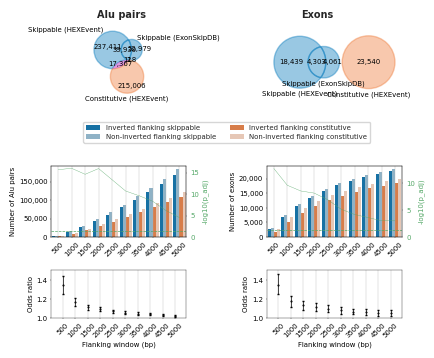

In [10]:
import general_plots
reload(general_plots)
import generate_enrichment_plots
reload(generate_enrichment_plots)
from general_plots import find_shared_alu_alu_pairs_any
from general_plots import find_shared_exons_any
from generate_enrichment_plots import *

plt.rcParams['font.family'] = 'DejaVu Sans'

mm_per_in = 25.4
target_width_in = 89 / mm_per_in
target_height_in = 74 /mm_per_in

height_ratios = [2, 1, 3, 2]
width_ratios = [1, 1]

fig = plt.figure(figsize=(target_width_in, target_height_in))
gs = gridspec.GridSpec(4, 2, height_ratios=[3, 0.05, 3, 2], width_ratios=[1, 1], hspace=0.7, wspace=0.6)
axs = []
for row in [0, 2, 3]:  # skip row 1 for the legend
    axs.append([fig.add_subplot(gs[row, col]) for col in range(2)])
axs = np.array(axs)
ax_legend = fig.add_subplot(gs[1, :])

find_shared_alu_alu_pairs_any(
    exons_df_list=[windows_subset_5000["skippable_hexevent"],
                   windows_subset_5000["skippable_exonskipdb"],
                   windows_subset_5000["constitutive"]],
    label_list=["Skippable (HEXEvent)", "Skippable (ExonSkipDB)", "Constitutive (HEXEvent)"],
    colour_list=[blue, blue, orange],
    file_type="bedops",
    ax=axs[0,0]
)

find_shared_exons_any(
    exons_df_list=[windows_subset_5000["skippable_hexevent"],
                   windows_subset_5000["skippable_exonskipdb"],
                   windows_subset_5000["constitutive"]],
    label_list=["Skippable (HEXEvent)", "Skippable (ExonSkipDB)", "Constitutive (HEXEvent)"],
    colour_list=[blue, blue, orange],
    file_type="bedops",
    ax=axs[0,1]
)

generate_enrichment_plot(
    enrich_plot_test_df,
    ylabel="Number of Alu pairs",
    legend=True,
    ax_legend=ax_legend,
    ax1=axs[1,0]
)

generate_enrichment_plot(
    enrich_plot_exon_test_df,
    ylabel="Number of exons",
    legend=False,
    ax1=axs[1,1]
)

plot_or(results_test_df, ax=axs[2,0])
plot_or(results_exon_test_df, ax=axs[2,1])

fig.text(0.2, 1.03, 'Alu pairs', ha='center', fontsize=7, fontfamily='DejaVu Sans', fontweight="bold") #26
fig.text(0.76, 1.03, 'Exons', ha='center', fontsize=7, fontfamily='DejaVu Sans', fontweight="bold")

print("Figure size (in inches):", fig.get_size_inches())
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1b_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1b_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()


#### Figure S1B

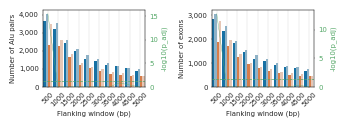

In [11]:
import generate_enrichment_plots
reload(generate_enrichment_plots)
from generate_enrichment_plots import *

width_ratios = [1, 1]
fig, axs = plt.subplots(1, 2, figsize=(3.5,1), gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.65}) #0.25

generate_enrichment_plot(
    enrich_plot_test_discrete_df,
    ylabel="Number of Alu pairs",
    xlabel=True,
    legend=False,
    #legend_pos="right",
    ax1=axs[0]
)

generate_enrichment_plot(
    enrich_plot_exon_test_discrete_df,
    ylabel="Number of exons",
    xlabel=True,
    legend=False,
    ax1=axs[1]
)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS1b_2024-10-23.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS1b_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure S1C

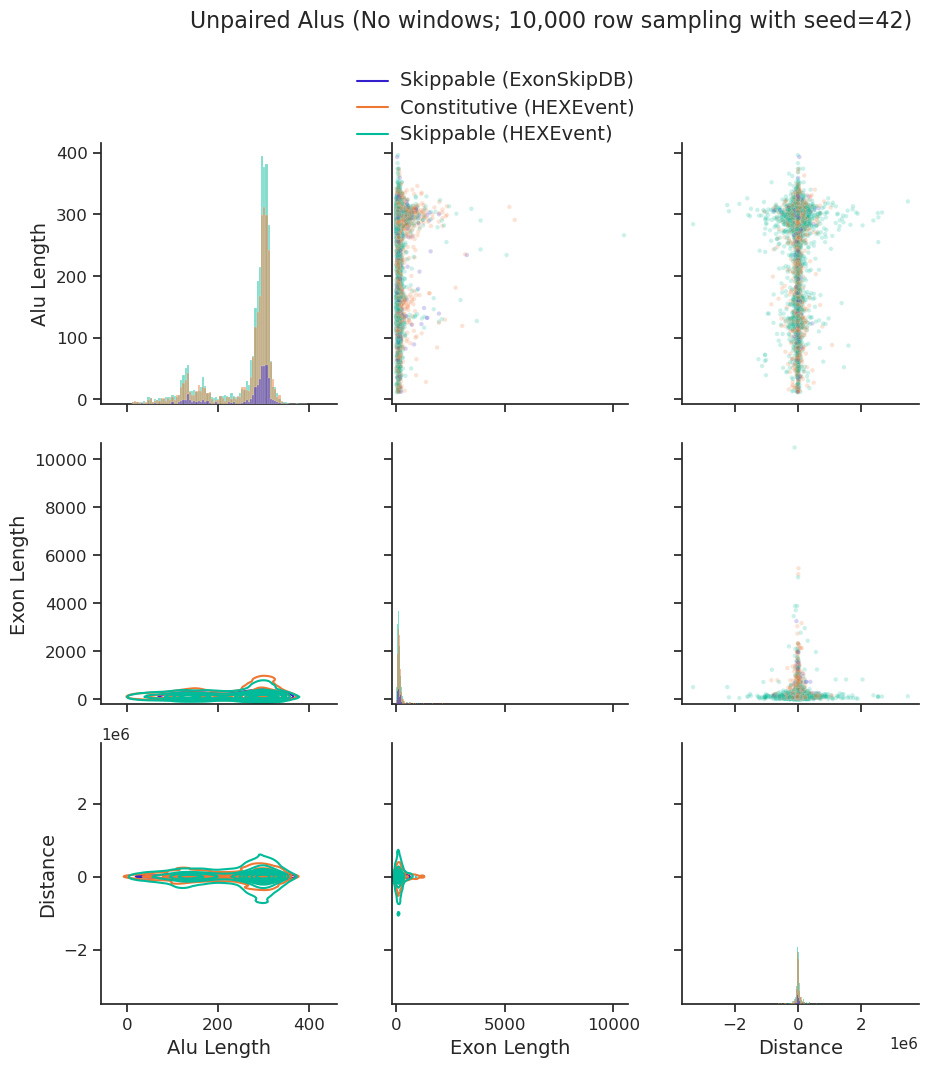

In [12]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

# run once since no window size
pairgrid_cols = ["alu_len", "exon_len", "dist", "label"]

skippable_hexevent_single_preflank_df = (
    add_label_col(windows_subset_5000["skippable_hexevent_single_preflank"], "skippable (hexevent)")
)
skippable_exonskipdb_single_preflank_df = (
    add_label_col(windows_subset_5000["skippable_exonskipdb_single_preflank"], "skippable (exonskipdb)")
)
constitutive_single_preflank_df = (
    add_label_col(windows_subset_5000["constitutive_single_preflank"], "constitutive (hexevent)")
)

concat_single_preflank_df = pd.concat([skippable_hexevent_single_preflank_df, #.query('-5000 <= dist <= 5000'),
                                       skippable_exonskipdb_single_preflank_df, #.query('-5000 <= dist <= 5000'),
                                       constitutive_single_preflank_df]) #.query('-5000 <= dist <= 5000')])
concat_single_preflank_df[["alu_len", "exon_len"]] = (
   add_alu_len_exon_len_cols(df=concat_single_preflank_df, pairs=False)
)

#display(concat_single_preflank_df["label"].value_counts())
#display(concat_single_preflank_df.columns)

# previously generate_pairgrid_plot()
generate_singlealu_pairgrid_plot(
    df=concat_single_preflank_df,
    cols=pairgrid_cols,
    nrows_sample=10000,
    window_size="No",
    title="Unpaired Alus"
)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1c_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1c_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure S1D

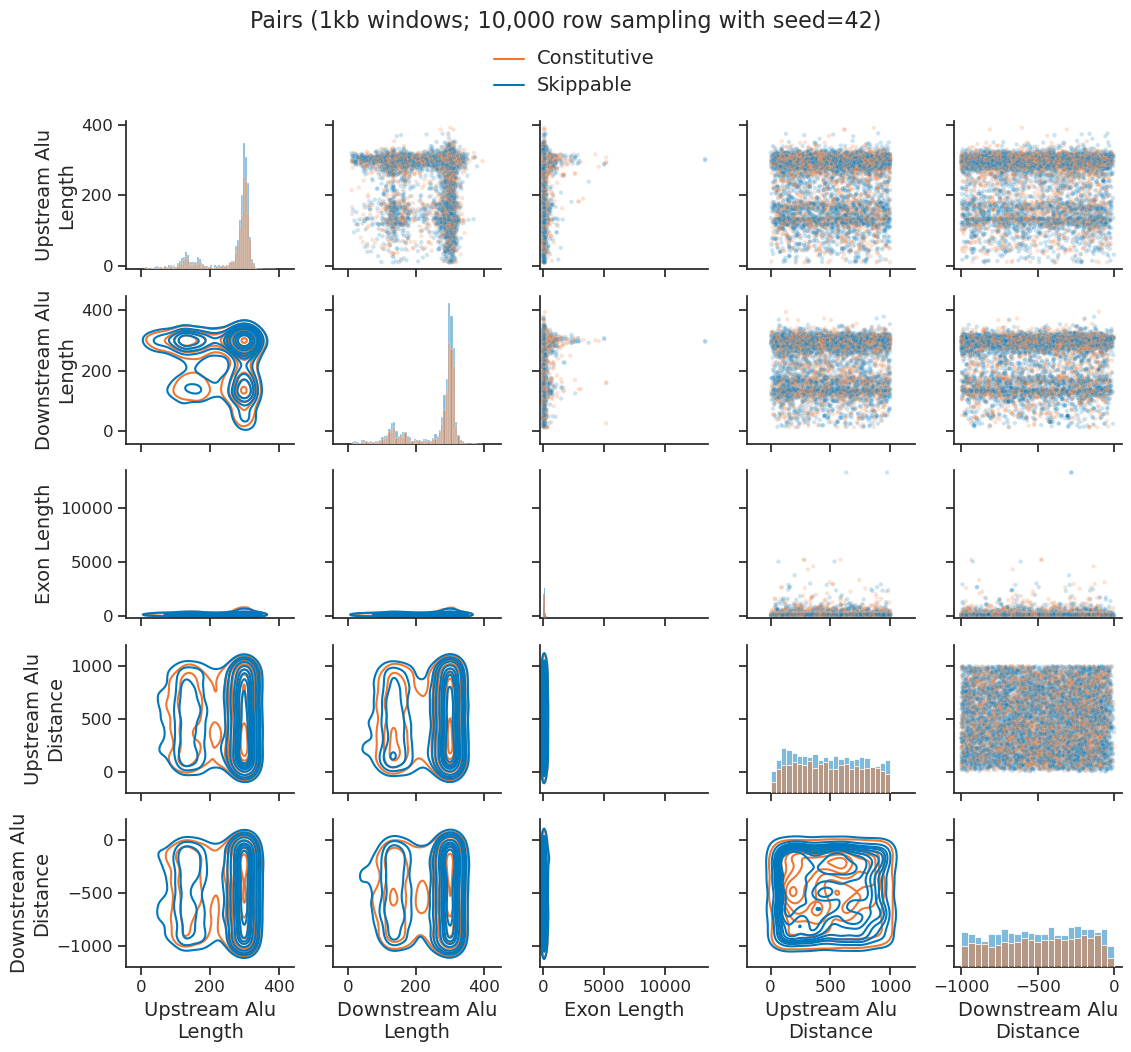

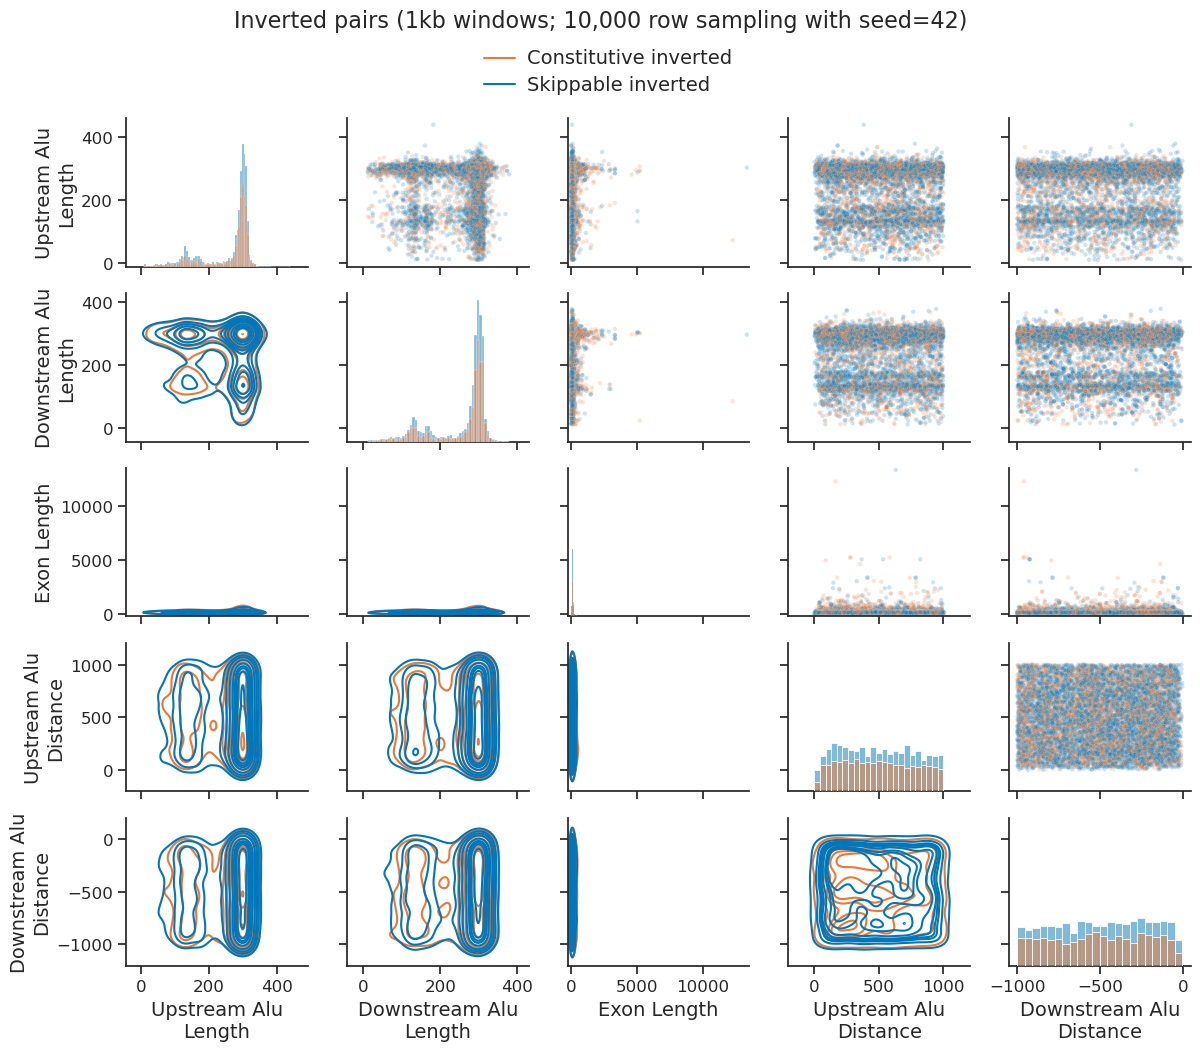

In [13]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

run_pairplot_window(alu_dct=windows_subset_1000, window="1kb",
                    ks_test=False, cv=0, n_sample=0, inverted=False)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-1kb_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-1kb_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

run_pairplot_window(alu_dct=windows_subset_1000, window="1kb",
                    ks_test=False, cv=0, n_sample=0, inverted=True)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-1kb-inverted_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-1kb-inverted_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

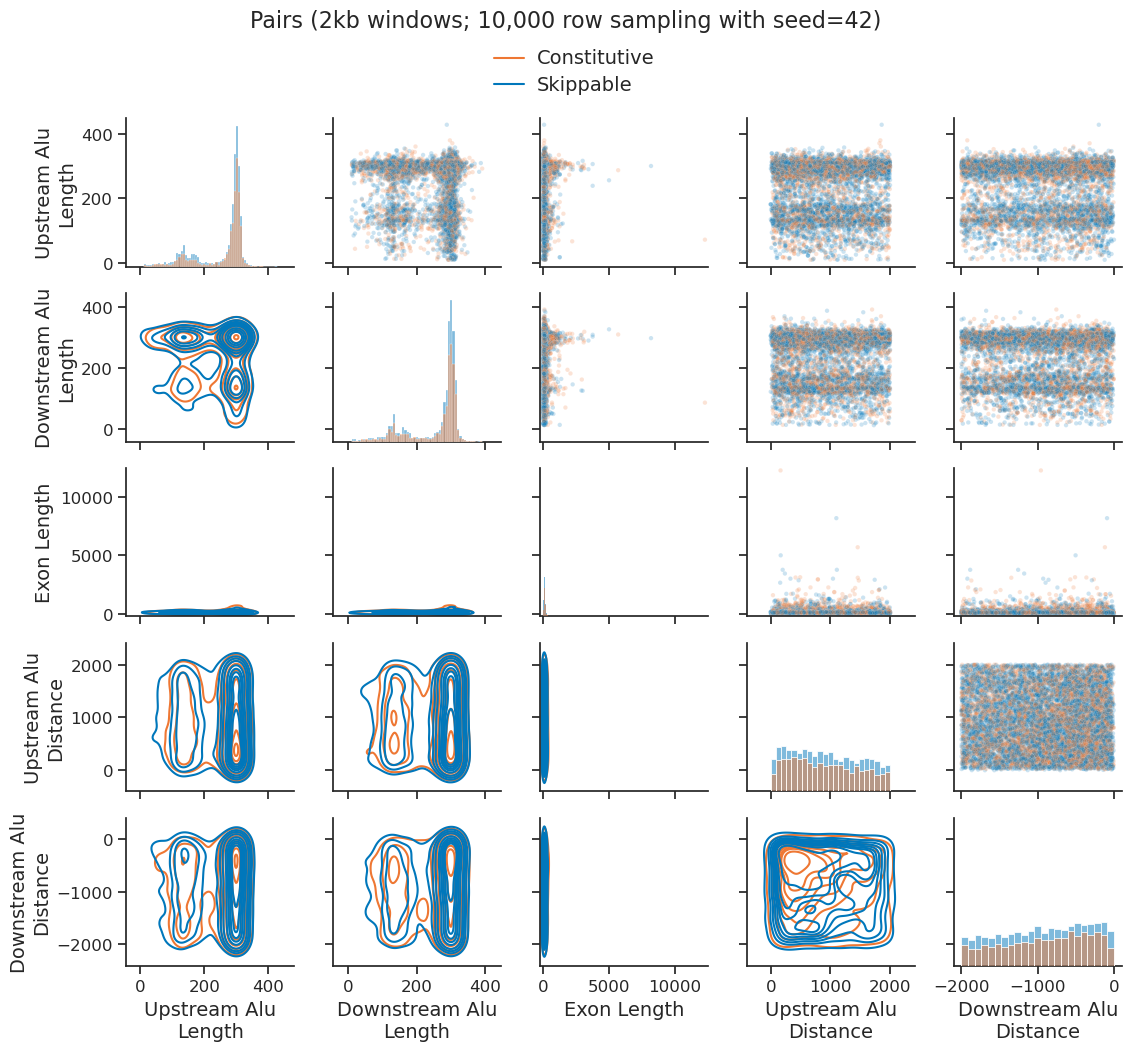

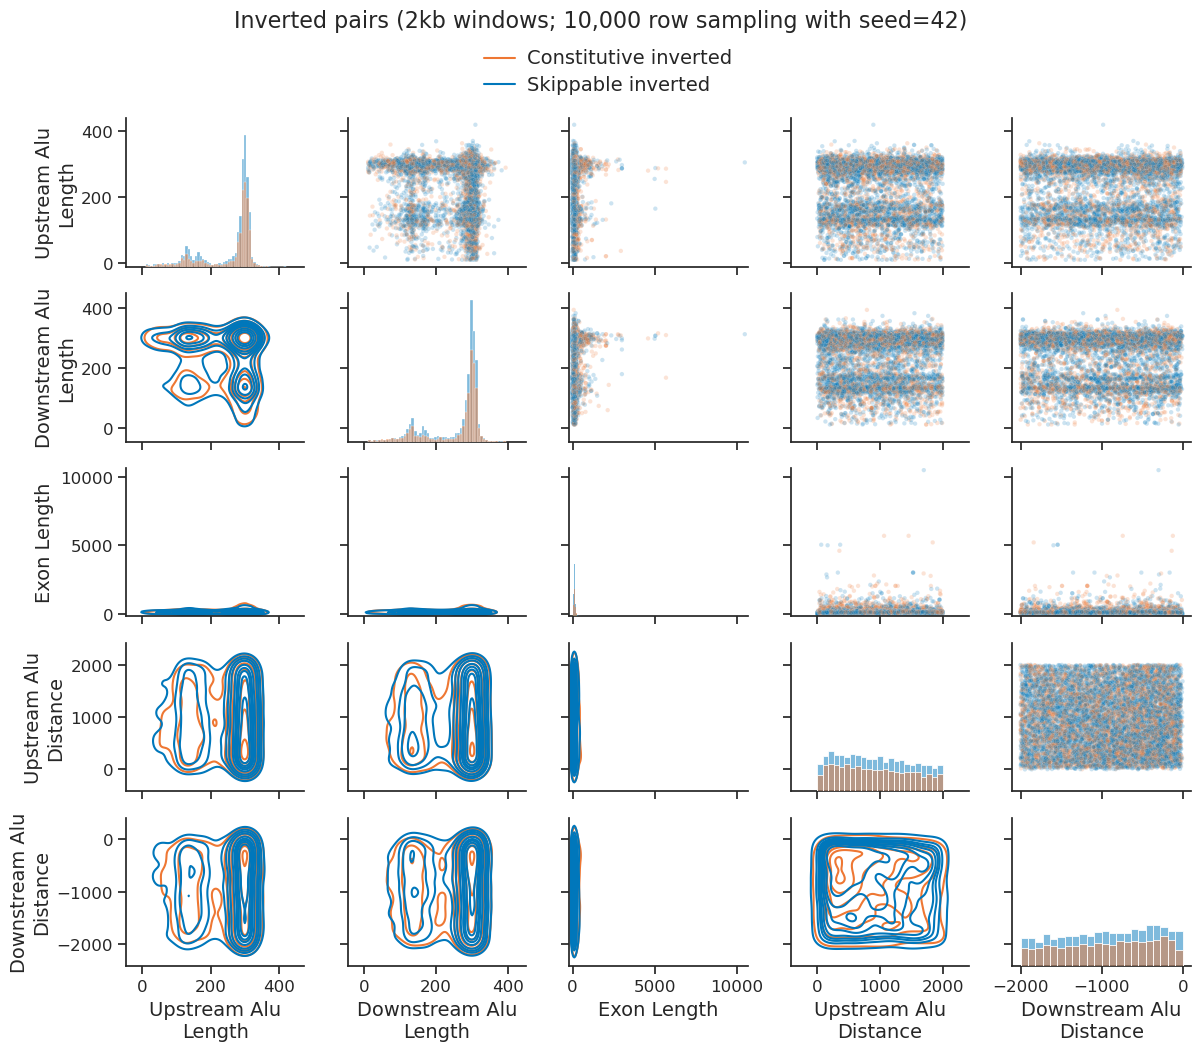

In [14]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

run_pairplot_window(alu_dct=windows_subset_2000, window="2kb",
                    ks_test=False, cv=0, n_sample=0, inverted=False)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-2kb_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-2kb_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

run_pairplot_window(alu_dct=windows_subset_2000, window="2kb",
                    ks_test=False, cv=0, n_sample=0, inverted=True)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-2kb-inverted_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-2kb-inverted_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

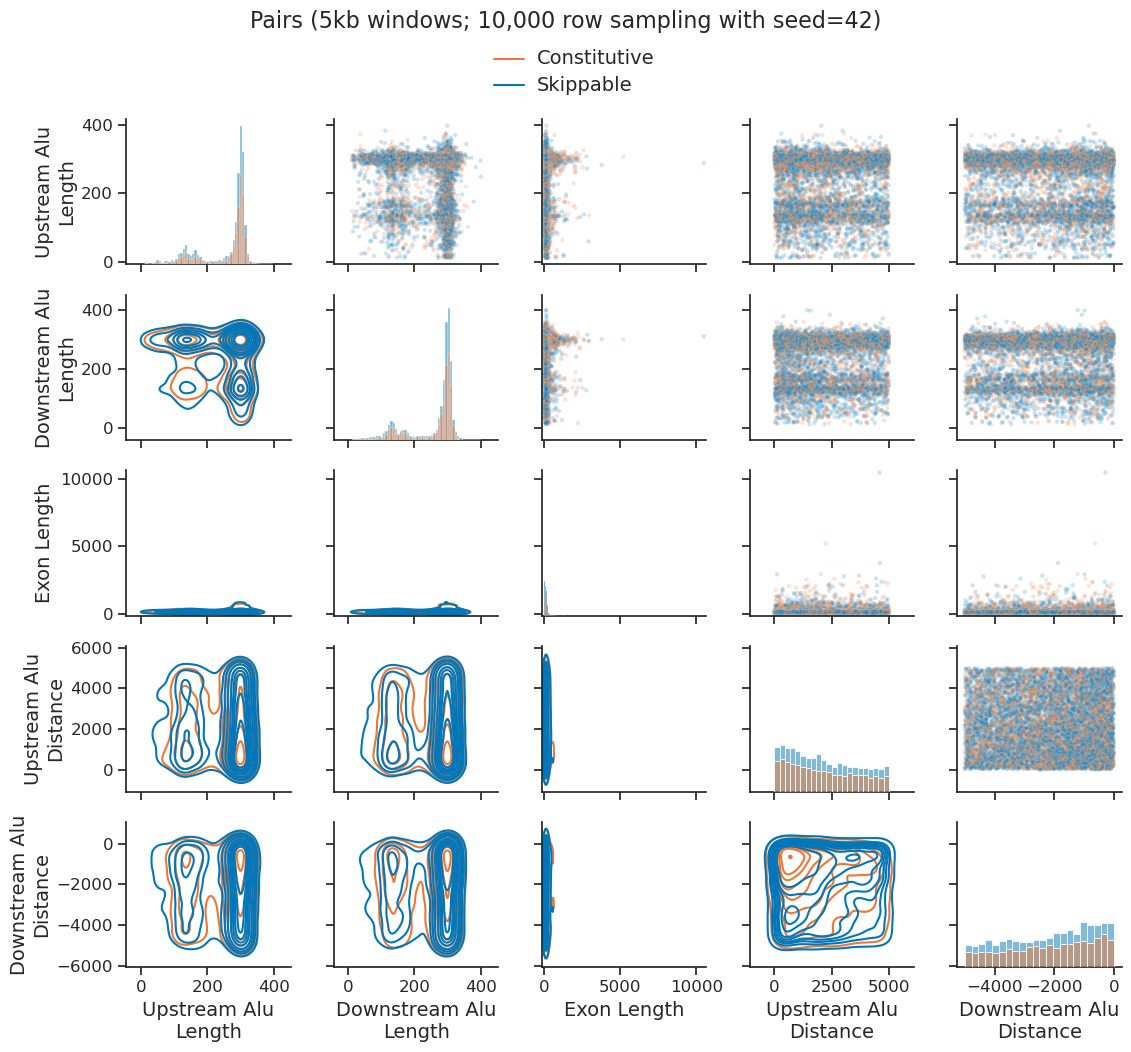

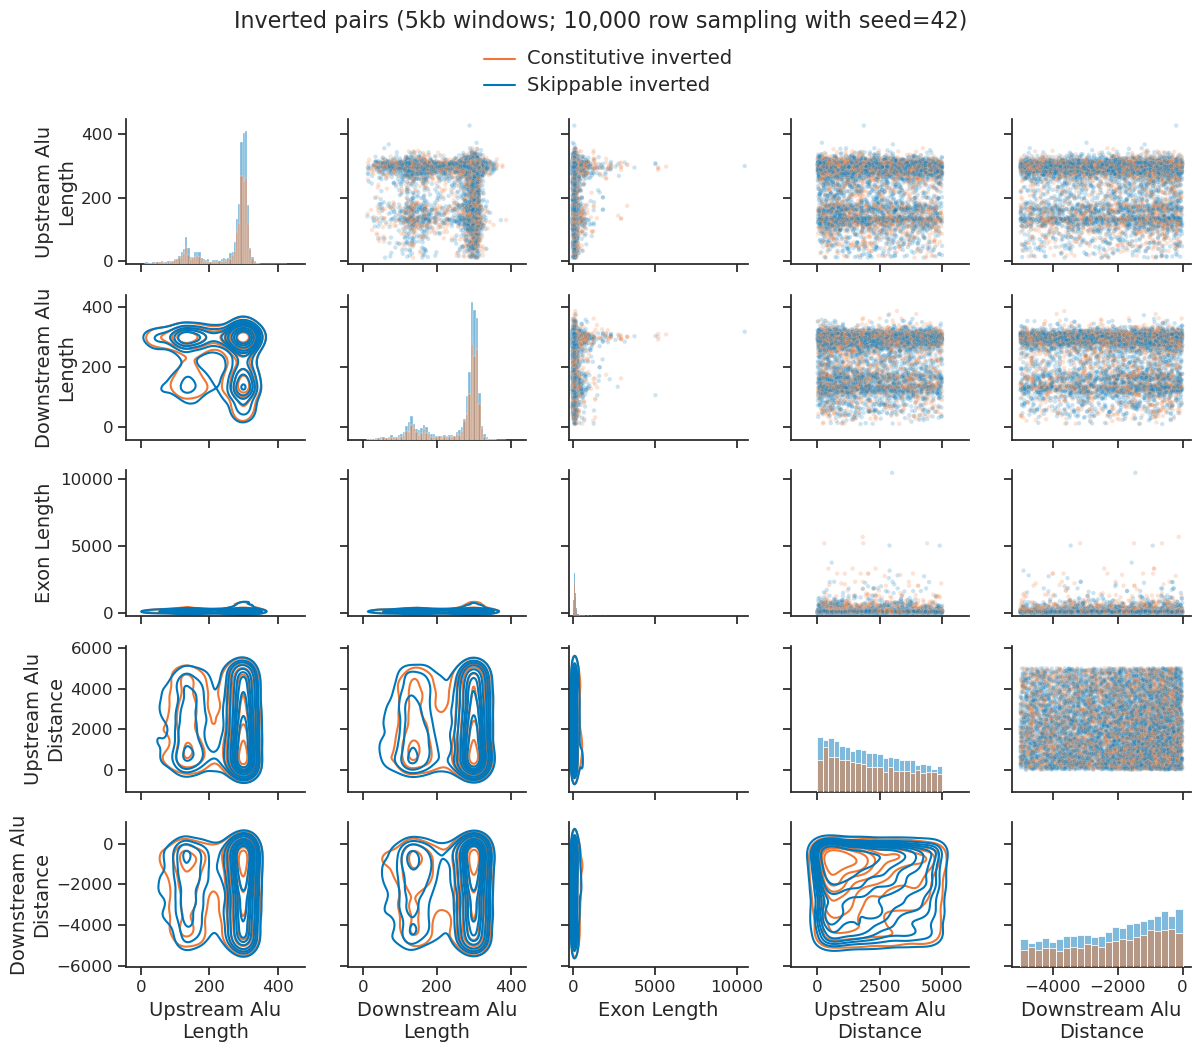

In [15]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

run_pairplot_window(alu_dct=windows_subset_5000, window="5kb",
                    ks_test=False, cv=0, n_sample=0, inverted=False)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-5kb_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-5kb_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

run_pairplot_window(alu_dct=windows_subset_5000, window="5kb",
                    ks_test=False, cv=0, n_sample=0, inverted=True)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-5kb-inverted_2024-10-11.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1d-5kb-inverted_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure 1C

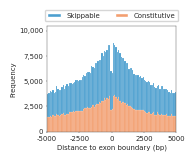

In [16]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (52/scaling_factor) / mm_per_in
target_height_in = (43/scaling_factor) /mm_per_in

width_ratios = [1]
fig, ax = plt.subplots(1, 1, figsize=(target_width_in, target_height_in), gridspec_kw={'width_ratios': width_ratios}) #(5,3)
plt.rcParams['font.family'] = 'DejaVu Sans'

plot_exon_length(alu_dct=windows_subset_5000, window="5kb", exon_distance=True, inv="inverted", ax=ax, show_title=False)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1c_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1c_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure S1E

non-inverted


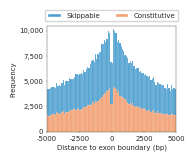

In [17]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (52/scaling_factor) / mm_per_in
target_height_in = (43/scaling_factor) /mm_per_in

width_ratios = [1]
fig, ax = plt.subplots(1, 1, figsize=(target_width_in, target_height_in), gridspec_kw={'width_ratios': width_ratios}) #(5,3)
plt.rcParams['font.family'] = 'DejaVu Sans'

print("non-inverted")
plot_exon_length(alu_dct=windows_subset_5000, window="5kb", exon_distance=True, inv="non-inverted", ax=ax, show_title=False)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS1e_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS1e_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

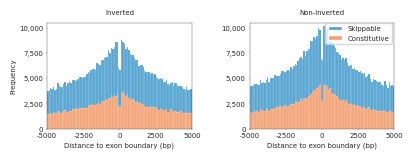

In [18]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (140/scaling_factor) / mm_per_in
target_height_in = (43/scaling_factor) /mm_per_in

width_ratios = [1, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), 
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.4}) #(15,4)

plt.rcParams['font.family'] = 'DejaVu Sans'
plot_exon_length(alu_dct=windows_subset_5000, window="5kb", exon_distance=True, inv="inverted", ax=axs[0])
plot_exon_length(alu_dct=windows_subset_5000, window="5kb", exon_distance=True, inv="non-inverted", ax=axs[1])
plt.show()

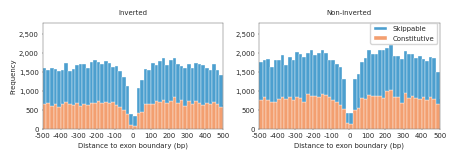

In [19]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (160/scaling_factor) / mm_per_in
target_height_in = (43/scaling_factor) /mm_per_in

width_ratios = [1, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), #(15,4)
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.2})

plot_exon_length(alu_dct=windows_subset_5000, window="5kb", exon_distance=True, zoom=True, inv="inverted", ax=axs[0])
plot_exon_length(alu_dct=windows_subset_5000, window="5kb", exon_distance=True, zoom=True, inv="non-inverted", ax=axs[1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1e-zoom_2024-10-11.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1e-zoom_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure 1D

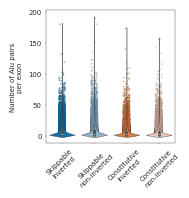

In [20]:
# Updated to use data before running MFE
# exon_strand is the first column that isn't part of groubpy_exons
data = pd.concat([groupby_exons(windows_subset_5000["skippable_inverted"])["exon_strand"].rename('Skippable\ninverted'), 
                  groupby_exons(windows_subset_5000["skippable_noninverted"])["exon_strand"].rename('Skippable\nnon-inverted'), 
                  groupby_exons(windows_subset_5000["constitutive_inverted"])["exon_strand"].rename('Constitutive\ninverted'), 
                  groupby_exons(windows_subset_5000["constitutive_noninverted"])["exon_strand"].rename('Constitutive\nnon-inverted')],
                 axis=1)

# The below works and was originally plotted for 5kb windows, however we wanted to move instead to include all entries before MFE
# data = pd.concat([groupby_exons(w_open_dct["5kb"]["skippable_inverted"])["index"].rename('Skippable\ninverted'), 
#                   groupby_exons(w_open_dct["5kb"]["skippable_noninverted"])["index"].rename('Skippable\nnon-inverted'), 
#                   groupby_exons(w_open_dct["5kb"]["constitutive_inverted"])["index"].rename('Constitutive\ninverted'), 
#                   groupby_exons(w_open_dct["5kb"]["constitutive_noninverted"])["index"].rename('Constitutive\nnon-inverted')],
#                  axis=1)

fontsize_min = 5

blue="#0077BB"
light_blue="#86B4CF"
orange="#EE7733"
light_orange="#EEC5AE"

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (52/scaling_factor) / mm_per_in
target_height_in = (54/scaling_factor) /mm_per_in

width_ratios = [1]
fig, ax = plt.subplots(1, 1, figsize=(target_width_in, target_height_in), #(5,3)
                       gridspec_kw={'width_ratios': width_ratios})

customPalette = [blue, light_blue, orange, light_orange]
plt.rcParams['font.family'] = 'DejaVu Sans'

sns.stripplot(
    data=pd.melt(data), x='variable', y='value', hue='variable',
    jitter=True, alpha=0.5, palette=customPalette, linewidth=0.1, 
    edgecolor='auto', zorder=0, ax=ax, size=1)
sns.violinplot(
    data=pd.melt(data), x='variable', y='value', hue='variable', 
    inner="box", palette=customPalette, 
    inner_kws=dict(box_width=2, whis_width=0.5, color=".3"), 
    zorder=1, ax=ax, linewidth=0.25)

# for collection in ax.collections:
#     collection.set_rasterized(True)
for collection in ax.collections:
    if isinstance(collection, mpl.collections.PathCollection):  # PathCollection represents the stripplot points
        collection.set_rasterized(True)

#sns.stripplot(data=pd.melt(data), x='variable', y='value', alpha=0.5, hue='variable')

plt.xlabel("")
plt.ylabel("Number of Alu pairs\nper exon", fontsize=fontsize_min) #fontsize=12

plt.xticks(rotation=45, fontsize=fontsize_min)
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize_min)
ax.tick_params(axis='both', which='both', length=1, width=0.25, pad=2)
#plt.yticks(fontsize=fontsize_min)
for spine in ax.spines.values():
    spine.set_linewidth(0.25)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1d-2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1d-2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure S1F

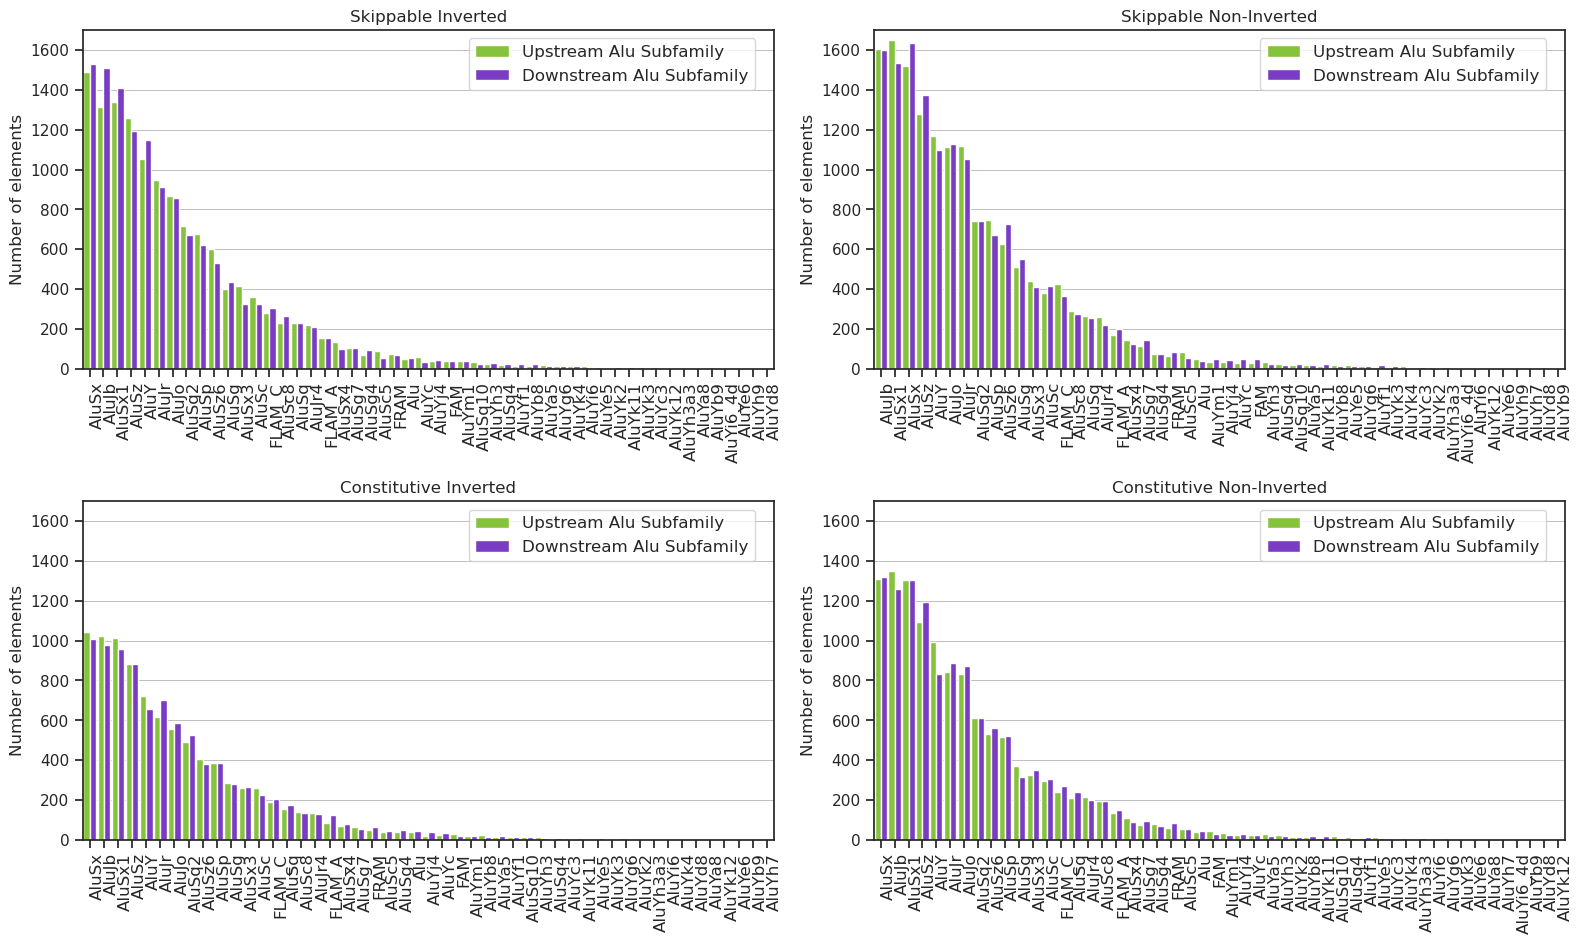

In [21]:
mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (500/scaling_factor) / mm_per_in
target_height_in = (300/scaling_factor) /mm_per_in
fontsize_min = 12

fig, axes = plt.subplots(2, 2, figsize=(target_width_in, target_height_in))  # 2x2 grid
axes = axes.flatten()

dfs_to_plot = ["skippable_inverted", "skippable_noninverted", "constitutive_inverted", "constitutive_noninverted"]

title_map = {
    "skippable_inverted": "Skippable Inverted",
    "skippable_noninverted": "Skippable Non-Inverted",
    "constitutive_inverted": "Constitutive Inverted",
    "constitutive_noninverted": "Constitutive Non-Inverted"
}

legend_map = {
    "upstream_alu_subfamily": "Upstream Alu Subfamily",
    "downstream_alu_subfamily": "Downstream Alu Subfamily"
}

custom_palette = {
    "Upstream Alu Subfamily": "#87DA25",
    "Downstream Alu Subfamily": "#7825DA"
}

for ax, (name, df) in zip(axes, {k: windows_subset_1000[k] for k in dfs_to_plot}.items()):
    #print(name)
    df_melted = pd.melt(df[["upstream_alu_subfamily", "downstream_alu_subfamily"]])
    df_melted['variable'] = df_melted['variable'].map(legend_map)
    #print(df_melted)
    sns.countplot(data=df_melted, x="value", hue="variable", order=df_melted["value"].value_counts().index, 
                  palette=custom_palette, ax=ax, edgecolor=None, width=0.9)
    ax.set_title(title_map[name], fontsize=fontsize_min)
    ax.set_xlabel("")
    ax.set_ylabel("Number of elements", fontsize=fontsize_min)
    ax.set_ylim(0,1700)
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(90)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', rotation_mode="anchor", fontsize=8)
    ax.tick_params(axis='x', rotation=90)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment
        label.set_rotation_mode('anchor')
        label.set_fontsize(fontsize_min)  # Set font size
    ax.legend(loc='upper right', bbox_to_anchor=(0.985, 1), fontsize=fontsize_min)
    ax.yaxis.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.7, zorder=1)
    ax.set_axisbelow(True)

plt.tight_layout()
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1f_2024-10-11.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1f_2024-10-11.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure 1E

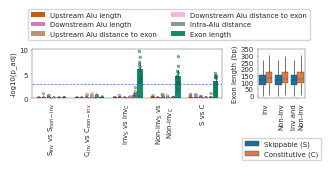

In [22]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (110/scaling_factor) / mm_per_in
target_height_in = (36/scaling_factor) /mm_per_in

height_ratios = [1, 3]
width_ratios = [4, 1]
fig = plt.figure(figsize=(target_width_in, target_height_in))
gs = gridspec.GridSpec(2, 2, 
                       height_ratios=height_ratios, width_ratios=width_ratios, 
                       hspace=0.7, wspace=0.3)
axs = []
axs.append([fig.add_subplot(gs[1, col]) for col in range(2)])
axs = np.array(axs)
ax_legend = fig.add_subplot(gs[0, :])

ks_dct_1kb = run_pairplot_window(alu_dct=windows_subset_1000, window="1kb", ks_test=True, cv=10, n_sample=1000)
plot_ks_result(ks_dct=ks_dct_1kb, window="1kb", cv=10, n_sample=1000, ax=axs[0,0], ax_legend=ax_legend)
plot_exon_length(alu_dct=windows_subset_1000, window="1kb", ax=axs[0,1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1e_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1e_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

In [23]:
for inv_type in ["inverted", "noninverted", "all"]:
    print(np.mean(ks_dct_1kb["exon_len"][inv_type]["pval"]))
    print(np.std(ks_dct_1kb["exon_len"][inv_type]["pval"]))

6.811960517736045e-06
1.4373257933617772e-05
0.0001476231031947006
0.00035982948015935036
0.0013940986767582136
0.003340551215500743


#### Figure S1G

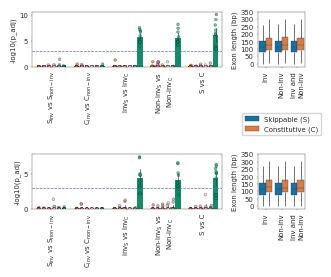

In [24]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

ks_dct_2kb = run_pairplot_window(alu_dct=windows_subset_2000, window="2kb", ks_test=True, cv=10, n_sample=1000)
ks_dct_5kb = run_pairplot_window(alu_dct=windows_subset_5000, window="5kb", ks_test=True, cv=10, n_sample=1000)

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (110/scaling_factor) / mm_per_in
target_height_in = (80/scaling_factor) /mm_per_in

width_ratios = [4, 1]
fig, axs = plt.subplots(2, 2, figsize=(target_width_in, target_height_in), 
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 1.6, 'wspace': 0.3}) # hspace 0.25

plot_ks_result(ks_dct=ks_dct_2kb, window="2kb", cv=10, n_sample=1000, ax=axs[0][0])
plot_exon_length(alu_dct=windows_subset_2000, window="2kb", ax=axs[0][1])

plot_ks_result(ks_dct=ks_dct_5kb, window="5kb", cv=10, n_sample=1000, show_legend=False, ax=axs[1][0])
plot_exon_length(alu_dct=windows_subset_5000, window="5kb", show_legend=False, ax=axs[1][1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1g_2024-10-11.svg"), bbox_inches="tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1g_2024-10-11.png"), dpi=300, bbox_inches="tight")
plt.show()

In [25]:
for inv_type in ["inverted", "noninverted", "all"]:
    print(np.mean(ks_dct_2kb["exon_len"][inv_type]["pval"]))
    print(np.std(ks_dct_2kb["exon_len"][inv_type]["pval"]))
print("\n")
for inv_type in ["inverted", "noninverted", "all"]:
    print(np.mean(ks_dct_5kb["exon_len"][inv_type]["pval"]))
    print(np.std(ks_dct_5kb["exon_len"][inv_type]["pval"]))

1.67932030312308e-06
3.1710553096627232e-06
2.05333081990502e-06
2.5685851275420335e-06
1.2631061434399983e-05
1.7525924250990174e-05


0.00013517196513144979
0.0002444602642421629
0.0001139339732197297
0.0002522872925957045
0.0004711461488032365
0.0008669767857747085


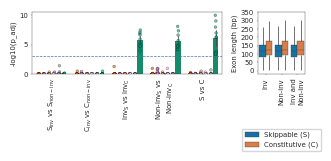

In [26]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *


ks_dct_2kb = run_pairplot_window(alu_dct=windows_subset_2000, window="2kb", ks_test=True, cv=10, n_sample=1000)

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (110/scaling_factor) / mm_per_in
target_height_in = (25/scaling_factor) /mm_per_in

width_ratios = [4, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), 
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.3})

plot_ks_result(ks_dct=ks_dct_2kb, window="2kb", cv=10, n_sample=1000, ax=axs[0])
plot_exon_length(alu_dct=windows_subset_2000, window="2kb", ax=axs[1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1g-2kb_2024-10-11.svg"), bbox_inches="tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1g-2kb_2024-10-11.png"), dpi=300, bbox_inches="tight")
plt.show()

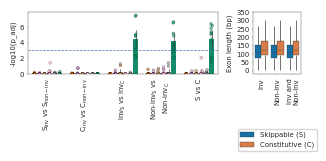

In [27]:
import alu_exon_characterization
reload(alu_exon_characterization)
from alu_exon_characterization import *

ks_dct_5kb = run_pairplot_window(alu_dct=windows_subset_5000, window="5kb", ks_test=True, cv=10, n_sample=1000)

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (110/scaling_factor) / mm_per_in
target_height_in = (25/scaling_factor) /mm_per_in

width_ratios = [4, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), 
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.3})

plot_ks_result(ks_dct=ks_dct_5kb, window="5kb", cv=10, n_sample=1000, ax=axs[0])
plot_exon_length(alu_dct=windows_subset_5000, window="5kb", ax=axs[1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1g-5kb_2024-10-11.svg"), bbox_inches="tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-11", "figureS1g-5kb_2024-10-11.png"), dpi=300, bbox_inches="tight")
plt.show()

#### Figure 1F

In [28]:
results_singlealuirpair   = open_pickle_enrich_dct('240418-results_singlealuirpair.pkl', pickle_dir)
results_aluirpair_comb    = open_pickle_enrich_dct('240419-results_aluirpair_comb.pkl', pickle_dir)

results_singlealuirpair_df = pd.concat(results_singlealuirpair, ignore_index=True)
results_aluirpair_comb_df  = pd.concat(results_aluirpair_comb, ignore_index=True)

results_aluirpair_comb_df["alu_subfamily_str2"] = results_aluirpair_comb_df["alu_subfamily"].apply(lambda x: ' '.join(x))
results_aluirpair_comb_df["alu_subfamily_str"] = results_aluirpair_comb_df["alu_subfamily"].apply(lambda x: '-'.join(x))
results_aluirpair_comb_df[["alu1_subfamily", "alu2_subfamily"]] = results_aluirpair_comb_df["alu_subfamily_str2"].str.split(' ', expand=True)

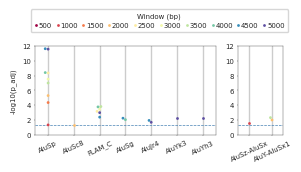

In [29]:
# create Figure 1F gridplot

import generate_enrichment_plots
reload(generate_enrichment_plots)
from generate_enrichment_plots import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (100/scaling_factor) / mm_per_in
target_height_in = (50/scaling_factor) /mm_per_in

# width_ratios = [2, 1]
# fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), 
#                         gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.15})

height_ratios = [1, 5]
width_ratios = [4, 1]
fig = plt.figure(figsize=(target_width_in, target_height_in))
gs = gridspec.GridSpec(2, 2, 
                       height_ratios=height_ratios, width_ratios=width_ratios, 
                       hspace=0.3, wspace=0.2)
axs = []
axs.append([fig.add_subplot(gs[1, col]) for col in range(2)])
axs = np.array(axs)
ax_legend = fig.add_subplot(gs[0, :])

swarmplot_p_values(results_singlealuirpair_df[results_singlealuirpair_df["case"] == 3], 
                   title=None, log=True, legend=False, ax=axs[0,0]) #axs[0]
swarmplot_p_values(results_aluirpair_comb_df, 
                   title=None, log=True, use_string=True, legend=True, legend_pos="right", ylabel=False, 
                   ax=axs[0,1], ax_legend=ax_legend) #axs[1]

#plt.tight_layout()
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1f_2024-10-23.svg"))
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure1f_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

In [30]:
results_aluirpair_comb_df[results_aluirpair_comb_df['bonferroni_reject_greater']]

fisher_greater_p  fisher_less_p  fisher_odds_ratio_greater  \
2406          0.000017       0.999991                   1.713797   
3972          0.000007       0.999995                   1.439676   
7797          0.000003       0.999997                   1.279973   

      fisher_odds_ratio_less                         table  r1c1  r1c2  r2c1  \
2406                1.713797      [[296, 174], [269, 271]]   296   174   269   
3972                1.439676      [[731, 424], [679, 567]]   731   424   679   
7797                1.279973  [[1669, 1019], [1620, 1266]]  1669  1019  1620   

      r2c2   alu_subfamily  bonferroni_reject_greater  bonferroni_p_greater  \
2406   271  (AluSz, AluSx)                       True              0.021327   
3972   567  (AluY, AluSx1)                       True              0.009204   
7797  1266  (AluY, AluSx1)                       True              0.004447   

      bonferroni_reject_less  bonferroni_p_less  window alu_subfamily_str2  \
2406                   False                1.0    1000        AluSz AluSx   
3972                   False                1.0    2000        AluY AluSx1   
7797                   False                1.0    3500        AluY AluSx1   

     alu_subfamily_str alu1_subfamily alu2_subfamily  
2406       AluSz-AluSx          AluSz          AluSx  
3972       AluY-AluSx1           AluY         AluSx1  
7797       AluY-AluSx1           AluY         AluSx1